# Evalutating Geneformer in zero-shot setting

In [ ]:
import os
import logging
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

from sc_foundation_evals import geneformer_forward as gf
from sc_foundation_evals import data, cell_embeddings, model_output
from sc_foundation_evals.helpers.custom_logging import log
log.setLevel(logging.INFO)

## Setting up variables

Define some variables, that we will rely on later, starting with paths and run configs.

In [2]:
geneformer_data = "../data/weights/Geneformer"
# path to the pre-trained model, can work with the huggingface model hub
# i.e. ctheodoris/Geneformer
model_dir = os.path.join(geneformer_data, "default")
# path to dictionaries in geneformer repo
dict_dir = os.path.join(geneformer_data, "dicts")

Alternatively to the code above, you can also use the snippet below, using the copy of the Genefomerme repository.

```python
repo_dir = "/path/to/repository/of/Geneformer"
model_dir = os.path.join(repo_dir)
dict_dir = os.path.join(repo_dir, "geneformer")
```

In [3]:
# batch_size depends on available GPU memory
batch_size = 24
# output_dir is the path to which the results should be saved
output_dir = "../output/geneformer/6L/"
# path to where we will store the embeddings and other evaluation outputs
model_out = os.path.join(output_dir, "model_outputs")
# if you can use multithreading specify num_workers, -1 means use all available
num_workers = -1

Data paths and configs.

I will be using the Pancreas dataset as an example, as described in the scGPT_zer-shot notebook.

In [4]:
# specify the path to anndata object
in_dataset_path = "../data/datasets/pancreas_scib.h5ad"
# dataset_name is inferred from in_dataset_path
dataset_name = os.path.basename(in_dataset_path).split(".")[0]
# specify the path for the output of the pre-processing
preprocessed_path = f"../data/datasets/geneformer/{dataset_name}/"
# create the preprocessed path if it does not exist
os.makedirs(preprocessed_path, exist_ok=True)
# in which column in adata.obs are gene names stored? if they are in index, the index will be copied to a column with this name
gene_col = "gene_symbols"
# batch column found in adata.obs
batch_col = "batch"
# where are labels stored in adata.obs? 
label_col = "celltype" #"str_labels"
# where the raw counts are stored?
layer_key = "counts" #"X" 

## Loading model and data

In [5]:
geneform = gf.Geneformer_instance(save_dir = output_dir, 
                                  saved_model_path = model_dir,
                                  explicit_save_dir = True,
                                  num_workers = num_workers)

INFO     | 2023-12-05 15:01:50 | Using device cuda


In [6]:
geneform.load_pretrained_model()

INFO     | 2023-12-05 15:01:52 | Model successfully loaded from ../data/weights/Geneformer/default


Load them vocabulary and gene to Ensembl ID matching.

In [7]:
geneform.load_vocab(dict_dir)

To prepare the data, we need to preprocess it and then tokenize it. First, we create the input data objec.

In [8]:
input_data = data.InputData(adata_dataset_path = in_dataset_path)

INFO     | 2023-12-05 15:01:52 | Loading data from ../data/datasets/pancreas_scib.h5ad


Then, we preprocess the data - match gene names and filter cells and genes. This will create a new adata, that will be saved in the `preprocessed_path` to a `.loom` or `.h5ad` file. Loom data seems to be causing more issues in this version of the Geneformer code, so I'll stick with this, but overall this should also work with adata format.

In [9]:
input_data.preprocess_data(gene_col = gene_col,
                           model_type = "geneformer",
                           save_ext = "loom",
                           gene_name_id_dict = geneform.gene_name_id,
                           preprocessed_path = preprocessed_path)

WARNING  | 2023-12-05 15:01:59 | Gene names not found in var columns. Using index instead.
INFO     | 2023-12-05 15:02:08 | Matched 94.30% genes (16388/17379) genes in vocabulary of size 40248.


Now, tokenizing the data. Preprocessing saves the data to a file, as the tokenizer expects to read it from drive. This will create a `dataset_name`.dataset directory with the tokenized data in the `preprocessed_path`. This will also read in the tokenized_data to the `geneform` object.

In [10]:
geneform.tokenize_data(adata_path = os.path.join(preprocessed_path, 
                                                 f"{dataset_name}.loom"),
                       dataset_path = preprocessed_path,
                       cell_type_col = label_col)


Tokenizing ../data/datasets/geneformer/pancreas_scib/pancreas_scib.loom
../data/datasets/geneformer/pancreas_scib/pancreas_scib.loom has no column attribute 'filter_pass'; tokenizing all cells.
Creating dataset.


Map (num_proc=6):   0%|          | 0/16382 [00:00<?, ? examples/s]

Map (num_proc=6):   0%|          | 0/16382 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/16382 [00:00<?, ? examples/s]

If the data was already tokenized, we can just load it.

```python
geneform.load_tokenized_dataset(os.path.join(preprocessed_path, f"{dataset_name}.dataset"))
input_data = data.InputData(adata_dataset_path = os.path.join(preprocessed_path, f"{dataset_name}.loom"))
```

## Evaluating model outputs

First, we will perform forward pass on the model and extract embeddings. We're interested with second to last layer, as per the instructions in the codebase of Geneformer [here](https://huggingface.co/ctheodoris/Geneformer/blob/main/geneformer/emb_extractor.py#L285). Using the argument `layer` we can refer to layers according to python logic (i.e. 0 is the embedding layer, 1 - first layer, 2 is the second layer, etc. and -1 is the last layer, etc.).

*Note:* If you get a CUDA out of memory error, you can try reducing the batch size. As a rule of thumb, try batch sizes of multiples of 8, to avoid potential issues with how approximations are handled in CUDA.

In [11]:
geneform.extract_embeddings(data = input_data,
                            batch_size = batch_size, 
                            layer = -2)

Geneformer (extracting embeddings):   0%|          | 0/683 [00:00<?, ?it/s]

In [12]:
eval_pred = model_output.GeneExprPredEval(geneform, 
                                          output_dir = model_out)

In [13]:
eval_pred.evaluate(n_cells = 500,
                   save_rankings = True)

,correlation,mean_correlation
count,500.000000,500.000000
mean,0.571496,0.661472
std,0.112216,0.112700
min,0.238710,0.401928
25%,0.487676,0.548921
50%,0.563608,0.719794
75%,0.667890,0.757058
max,0.815732,0.809235


INFO     | 2023-12-05 15:07:41 | Subsetting to 100 cells


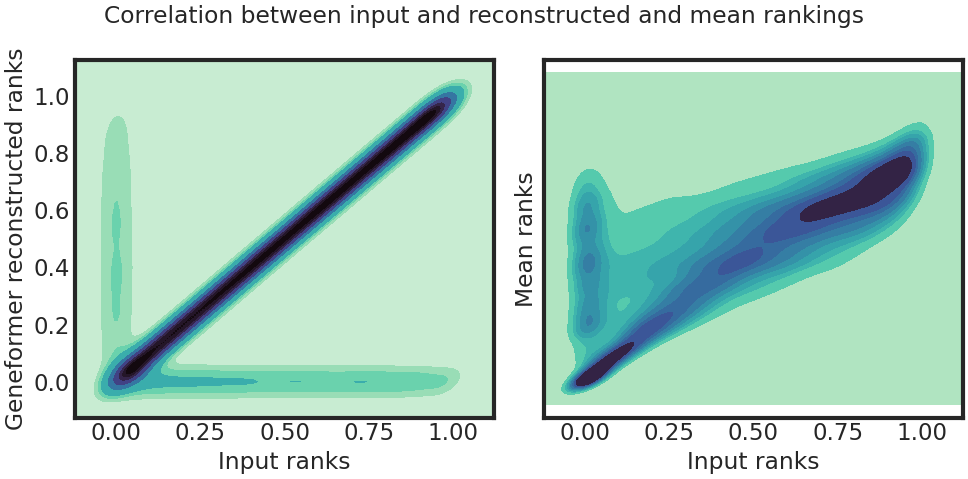

In [14]:
eval_pred.visualize(n_cells = 100, cmap = "mako_r")

# Evaluate the cell embeddings

First, creating cell embeddings evaluation object.

In [15]:
eval_ce = cell_embeddings.CellEmbeddingsEval(geneform,
                                             data = input_data,
                                             output_dir = model_out,
                                             label_key = label_col,
                                             batch_key = batch_col)


Then, evaluating the embeddings. Here, for speed we are subsetting the data to 1000 cells.

In [16]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 1000, embedding_key = "geneformer")

WARNING  | 2023-12-05 15:13:20 | adata_ has 16382 cells. Taking a subset of 1000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.091457
1,ARI_cluster/label,celltype,0.023780
2,ASW_label,celltype,0.323220
3,graph_conn,celltype,0.476560
4,ASW_batch,celltype,0.622801
5,ASW_label/batch,celltype,0.676177
6,PCR_batch,celltype,0.632914
7,avg_bio,celltype,0.146152


In [17]:
# with n_cells you can specify how much to subset the obs for
eval_ce.evaluate(n_cells = 1000, embedding_key = "geneformer")

WARNING  | 2023-12-05 15:13:28 | adata_ has 16382 cells. Taking a subset of 1000 cells.


,metric,label,value
0,NMI_cluster/label,celltype,0.091457
1,ARI_cluster/label,celltype,0.023780
2,ASW_label,celltype,0.323220
3,graph_conn,celltype,0.476560
4,ASW_batch,celltype,0.622801
5,ASW_label/batch,celltype,0.676177
6,PCR_batch,celltype,0.632914
7,avg_bio,celltype,0.146152


WARNING  | 2023-12-05 15:14:52 | adata_ has 16382 cells. Taking a subset of 7500 cells.
WARNING  | 2023-12-05 15:14:53 | More than 10 labels for celltype.The plots might be hard to read.


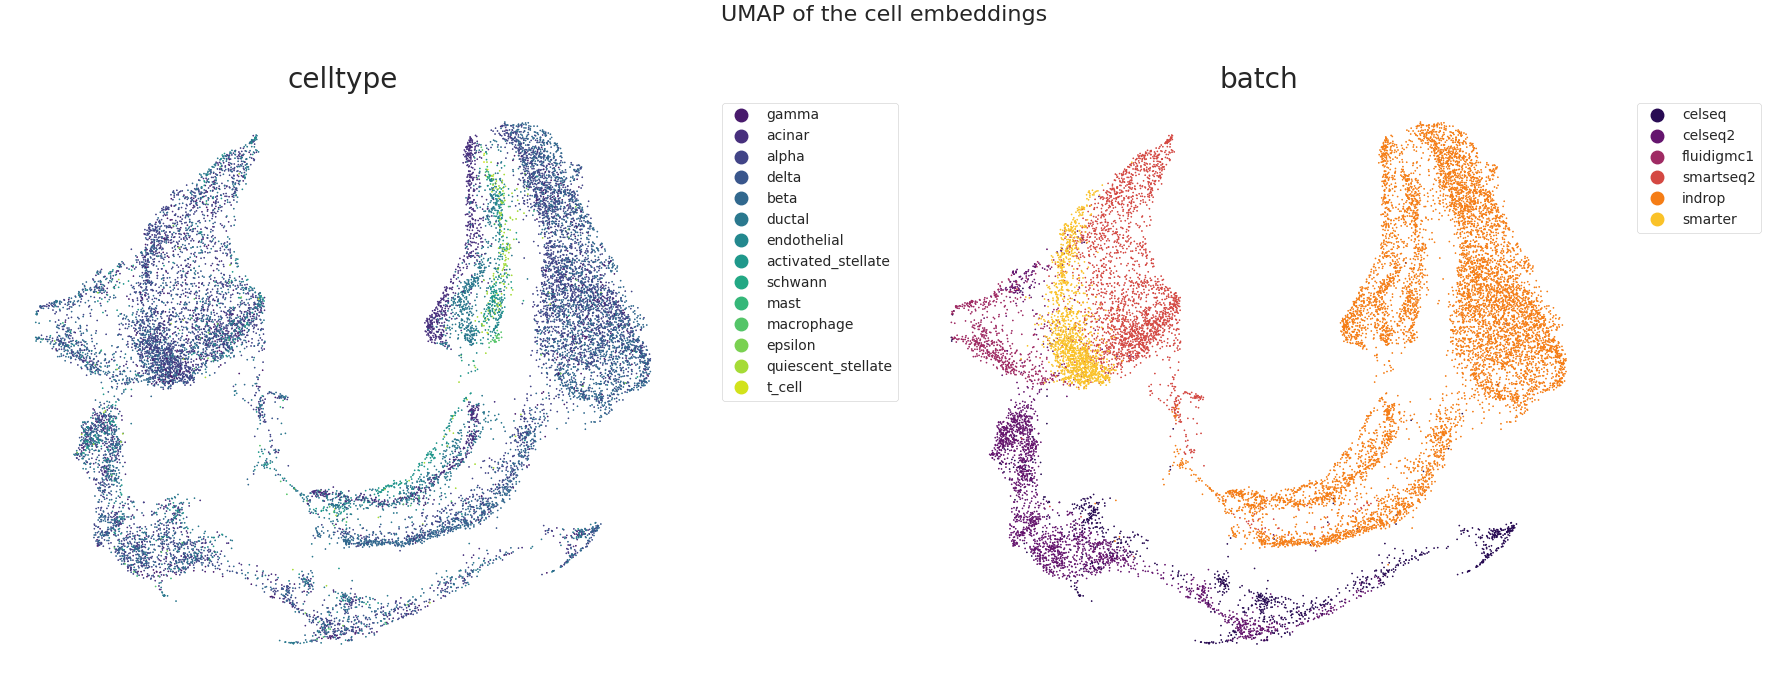

In [18]:
eval_ce.visualize(embedding_key = "geneformer")